# Simulation using the spectral method

In [2]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

import time

import os, sys
sys.path.insert(0, os.path.abspath(".."))

from _utils import plot

## Solving the advection equation

In [3]:
key = jax.random.PRNGKey(int(time.time()))
u = jax.random.uniform(key=key, shape=(5,))

uhat = jnp.fft.fft(u)
for i in uhat:
    print(i.real, i.imag)

2.1103656 0.0
-0.113176405 0.023552835
-0.41202906 1.0390573
-0.41202906 -1.0390573
-0.113176405 -0.023552835


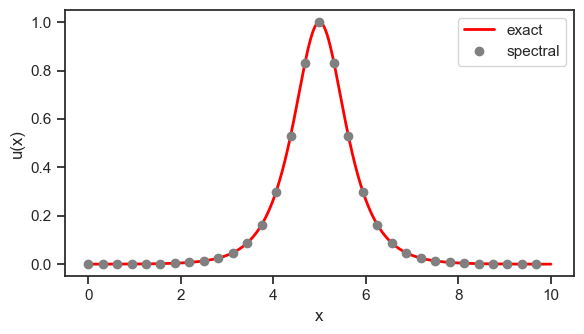

In [4]:
L   = 10.0
nx  = 32
a   = 1.0
cfl = 0.9

#---------- solution domain, initial condition

dx = L/nx     # not L/(nx-1)
x = jnp.linspace(0.0, L-dx, nx)
u0 = 1.0/(jnp.cosh(2.0*(x-5.0)))

#---------- exact solution with more points for plotting

xx  = jnp.linspace(0.0, L, 1000)
uu  = 1.0/(jnp.cosh(2.0*(xx-5.0)))

#---------- solve the problem and plot

def rhsf(u, t):
    N = len(u)
    n = jnp.arange(N) 
    n.at[int(N/2)+1:].set(n[int(N/2)+1:]-N)
    return -a*jnp.fft.ifft(2*jnp.pi*1j*n/L*jnp.fft.fft(u)).real

t = jnp.linspace(0,10,11)
y = odeint(rhsf, u0, t)

ax = plot(xx,uu, '-', color='red', lw=2, label="exact")
plot(x,y[-1,:], 'o', color='gray', lw=1, label="spectral", ax=ax, x_label='x', y_label=r'u(x)');

## Gradient-based optimisation

In [27]:
x  = jnp.linspace(0.0, L, nx)
ufinal  = 1.0/(jnp.cosh(2.0*(x-5.0)))
u0 = jnp.zeros_like(x)

@jax.jit
def loss(u0, t):
    upred = odeint(rhsf, u0, t)
    return jnp.mean((ufinal - upred[-1,:])**2)

LR = 1e+0
for i in range(50):
    grad = jax.grad(loss)(u0, t)
    u0 = u0 - LR*grad
    if i%5==0:
        print("Step: %i \t Loss: %.5f"% (i, loss(u0, t)))

Step: 0 	 Loss: 0.08514
Step: 5 	 Loss: 0.04465
Step: 10 	 Loss: 0.02342
Step: 15 	 Loss: 0.01228
Step: 20 	 Loss: 0.00644
Step: 25 	 Loss: 0.00338
Step: 30 	 Loss: 0.00177
Step: 35 	 Loss: 0.00093
Step: 40 	 Loss: 0.00049
Step: 45 	 Loss: 0.00026


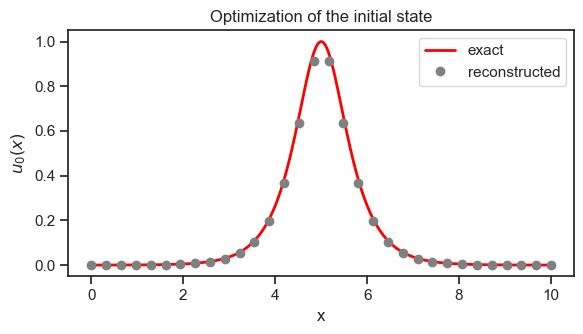

In [28]:
u0exact = 1.0/(jnp.cosh(2.0*(xx-5.0)))
ax = plot(xx, u0exact, '-', color='red', lw=2, label="exact", title="Optimization of the initial state")
plot(x, u0, 'o', color='gray', lw=1, label="reconstructed", ax=ax, x_label='x', y_label=r'$u_0(x)$');

## Findings
- The spectral method can be used to solve PDE differentiably
- No need for diffrax, but in case we do need a Neural Network, let's use it


## Next step
- The Navier-Stokes equation